# LAMA Lab No. 8: Timeseries Forecasting & Recurrent Neural Networks

# 1 Introduction & Overview

In this task, you will be introduced to timeseries forecasting. A timeseries is a sequence of observations in time, typically available as pairs of timestamps and numerical values for multiple features. For timeseries forecasting, as the name implies, we are trying to predict future values based on the past of the timeseries.
These kinds of tasks have a wide range of applications, including weather/climate forecasting, economic/business forecasting, epidemiology, or even signal processing.

A wide range of models are applicable for this kind of analysis. To keep the extent of this notebook to a reasonable amount, we'll only cover neural network-based models in this task, specifically fully-connected, vanilla RNN and LSTM models, among with some baseline models. If you're planning on doing timeseries forecasting yourself in the future, you might also want to take a look at the following things as well:

- [Linear Prediction](https://en.wikipedia.org/wiki/Linear_prediction): predicts the next value by linear combination of past values. Used e.g. in audio & image compression.
- [ARIMA](https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average): one of the most widely used approaches in econometrics. Could be seen as a more complex version of linear prediction, and very similar to the ARMA models you might be familiar with from the lecture Signals and Systems. Compared to ARMA models, ARIMA models better suited for nonstationary processes.
- [Prophet](https://facebook.github.io/prophet/): not a model itself, but a library by Facebook/Meta focused on timeseries forecasting. Beware of claims that this library can reliably outperform all competing models, as those turned out to not be true and have since been implicitely retracted. Nevertheless still something you can try, and definitely not a bad library.

This notebook is based on the [timeseries forecasting](https://www.tensorflow.org/tutorials/structured_data/time_series) tutorial by the TensorFlow team. The original tutorial contains some additional models we don't cover in this task, specifically linear models, CNNs, residual models, and autoregressive models built from single-step models. In case you are deeply interested in the variety of models available for timeseries forecasting, it might be interesting to also take a look at their notebook.

## 1.1 Our problem
In this notebook, you will work with a simple timeseries dataset containing weather data collected by the Max-Planck-Institut für Biogeochemie in Jena. They are continously collecting data on multiple different variables of three weather stations. We'll be using a version of the dataset prepared by the TensorFlow team for their [timeseries forecasting](https://www.tensorflow.org/tutorials/structured_data/time_series) tutorial, which contains 7 years of timeseries data from one of the weather stations in a single csv file. Based on this data, we will try to predict the future progression of temperature and other weather variables from a range of past values.

## 1.2 Notebook structure
This notebook is split into two main chapters: "Preparation & Preprocessing", where we analyze our data and prepare it for our various models, and "Machine Learning", where we learn about RNNs and LSTMs, train a range of different models and introduce new, useful (beyond timeseries & RNN tasks) concepts along the way.

## 1.3 A quick note on this notebook

(WS 2021 / 2022) This is a completely new notebook developed from the ground up. Even though there was a task with a similar topic in previous LAMAs, this notebook shares nothing with the old one. We tested everything internally, so the tasks should hopefully be doable and completable in a reasonable amount of time, but there might still be a few "rough edges" left. If you notice anything, please let us know in the feedback at the end of the notebook, so that we can make this notebook as good as possible for future students. If there is something that really prevents you from working on the notebook properly, please send us a quick email (or talk to us during the lab session of course), so that we can help you & the other students who might end up facing a similar problem.

Finally, RNNs take quite a lot of computing power to train & run. You'll probably want to use a decently powerful computer to run them, especially for 3.4.

# 2 Preparation & Preprocessing

**Note**: you might have to install the `statsmodels` package manually, if it is not already present in your environment. You can do this either by calling `conda install statsmodels` (replacing `conda` with `pip` if you're not using (Ana)conda) in a terminal with the correct environment activated, or via the Anaconda UI.

In [128]:
import os
import datetime
import math
from typing import *

import numpy as np
import pandas as pd

import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.preprocessing
import statsmodels.graphics.tsaplots

## 2.1 Preparation

### 2.1.1 Loading the dataset

In [129]:
# Keras has a nice function which enables us to dynamically download and cache datasets
# It even extracts zip files for us if we want it to
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
print(f'Dataset at {zip_path}')
# In this case, the filename of the csv file we want to read is the same as the zip file,
# just without the ".zip" at the end, which we can remove via os.path.splitext[ension]
csv_path = os.path.splitext(zip_path)[0]
print(f'CSV at {csv_path}')

# Parse the csv file into a dataframe
df = pd.read_csv(csv_path)

df.head()

Dataset at C:\Users\uhvmz\.keras\datasets\jena_climate_2009_2016.csv.zip
CSV at C:\Users\uhvmz\.keras\datasets\jena_climate_2009_2016.csv


,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


### 2.1.2 Time Formats

<div class="alert alert-block alert-success">
<b>Task:</b> Convert the "Date Time" column from string to datetime objects using pd.to_datetime(), and set this converted column as the new index of the dataframe.
</div>

In [130]:
# STUDENT CODE HERE (2 pts)

df["Date Time"] = pd.to_datetime(df["Date Time"],format='%d.%m.%Y %X')

df.set_index('Date Time')

print(df["Date Time"])

# STUDENT CODE until HERE

df.head()

0        2009-01-01 00:10:00
1        2009-01-01 00:20:00
2        2009-01-01 00:30:00
3        2009-01-01 00:40:00
4        2009-01-01 00:50:00
                 ...        
420546   2016-12-31 23:20:00
420547   2016-12-31 23:30:00
420548   2016-12-31 23:40:00
420549   2016-12-31 23:50:00
420550   2017-01-01 00:00:00
Name: Date Time, Length: 420551, dtype: datetime64[ns]


,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,2009-01-01 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,2009-01-01 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,2009-01-01 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,2009-01-01 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,2009-01-01 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


### 2.1.3 Invalid value checks


<div class="alert alert-block alert-success">
<b>Task:</b> Check if any NaN values are present in the dataframe, e.g. by counting the number of rows containing NaN values.
</div>

In [131]:
# STUDENT CODE HERE (1 pts)

numberNaN=df.isnull().sum().sum()
print(numberNaN)

# STUDENT CODE until HERE

0


Great, our dataset doesn't contain any NaN values. So let's move on to some preprocessing.
To make things a little bit easier, let's just work with one time step per hour instead of one every 10 minutes. We can do this by averaging the values over each hour and then using those values.

### 2.1.4 Resampling

<div class="alert alert-block alert-success">
<b>Task:</b> Resample the dataframe so that we obtain one value per hour instead of one every 10 minutes. Use the df.resample() method and take the mean value over the timesteps in each interval. Make sure that the resulting index is either of the type pd.Period or pd.Timestamp (this is checked for you via the given assertion).
</div>

In [132]:
df_resampled: pd.DataFrame

# STUDENT CODE HERE (1 pts)

df_resampled=df.resample('H', on="Date Time").mean()

# STUDENT CODE until HERE

# Assert correct index type
assert isinstance(df_resampled.index[0], pd.Period) or isinstance(df_resampled.index[0], pd.Timestamp)
# Assert correct length
assert len(df_resampled) == 70_129

### 2.1.5 Invalid value checks (round 2)

<div class="alert alert-block alert-success">
<b>Task:</b> Check if any NaN values are present in the resampled dataframe, and, if there are some, print out the times at which they occur. Feel free to just copy over the code from earlier as a start.
</div>

In [133]:
# STUDENT CODE HERE (2 pts)

numberNaN=df_resampled.isnull().sum()
print(numberNaN)

# STUDENT CODE until HERE

p (mbar)           88
T (degC)           88
Tpot (K)           88
Tdew (degC)        88
rh (%)             88
VPmax (mbar)       88
VPact (mbar)       88
VPdef (mbar)       88
sh (g/kg)          88
H2OC (mmol/mol)    88
rho (g/m**3)       88
wv (m/s)           88
max. wv (m/s)      88
wd (deg)           88
dtype: int64


<div class="alert alert-block alert-success">
<b>Question(2 pts):</b> Where did those NaN entries come from? Why didn't we discover them before when we checked the first time?
</div>

<div class="alert alert-block alert-success">
<b>Answer:</b>if there are timespans without any input valuse, the resample method creates nan values for these timespwans even though we havent nan values in the dataset </div>

Now, there are many ways of dealing with NaN values, some of which we already covered in previous exercises. If only single values are missing, it is of course easy to just interpolate them from their neighbors. Another more general method that is often used is to replace them with some constant value, e.g. the mean of the dataset. As we're missing relatively long (multiple hours to a few days) timespans and want to apply models that heavily depend on the periodicity of the data, we'll use another method and just cut out 24h-chunks around the missing timespans. That way, there might be tiny remaining discontinuities where values were missing previously, but the general periodicity is preserved.

<div class="alert alert-block alert-success">
<b>Task:</b> Implement the method below that removes the minimal amount of 24h-chunks necessary to remove all NaN entries from the dataframe. Sanity checks for your output are provided in the code after the method, so if your method is incorrect, the assertion that fails might be helpful in finding the issue. Hint: if your code fails only the last assertion, you're removing 24h (or n * 24h) of timesteps unnecessarily. If you can't figure out how to fix this, you can go ahead and do the rest of the notebook first, commenting out that assertion - everything will run basically the same. Then, in the end, come back and fix your method.
</div>

In [7]:
def cut_out_nans_preserving_day_periodicity(dataframe: pd.DataFrame) -> pd.DataFrame:
    """Returns new dataframe, where all rows containing NaN values are cut out
       in such a way that day (24h) periodicity is preserved.

    Args:
        dataframe (pd.DataFrame): The dataframe potentially containing some rows with NaN values.

    Returns:
        pd.DataFrame: An equivalent dataframe of the input dataframe, but with some time steps removed.
    """
    # STUDENT CODE HERE (4 pts)
    nan_days = set()
    useless_dates=[]
    
    for index, row in dataframe.iterrows():
        if row.isna().any():
            nan_days.add(index.date())

    for index, row in dataframe.iterrows():
        if index.date() in nan_days:
            useless_dates.append(index)
    
    return dataframe.drop(index=useless_dates)
     
    # STUDENT CODE until HERE

# Apply our method
df_resampled_cut = cut_out_nans_preserving_day_periodicity(df_resampled)
print(df_resampled_cut.isnull().values.max(axis=1).sum())



# Assert that no NaN values are left (yes, you can copy this code to solve an earlier task, but that's lame)
assert df_resampled_cut.isnull().values.max(axis=1).sum() == 0
# Assert that all entries of the dataframe are 1 hour (+ n days) apart from each other
assert (((df_resampled_cut.index[1:] - df_resampled_cut.index[:-1])
       .map(lambda d: d % pd.Timedelta('1D'))) == pd.Timedelta('1H')).all()
# Assert that you only removed the minimal necessary amount of time steps
# This check obviously is not really possible in practical situations
#assert len(df_resampled_cut) >= 70_009

# If everything checks out, overwrite the df_resampled dataframe with our new one
df_resampled = df_resampled_cut

0


### 2.1.6 Looking at the data

Let's take a look at some simple descriptive statistics of our dataset to see if everything is in order now.

In [8]:
df_resampled.describe()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
count,69985.000000,69985.000000,69985.000000,69985.000000,69985.000000,69985.000000,69985.000000,69985.000000,69985.000000,69985.000000,69985.000000,69985.000000,69985.000000,69985.000000
mean,989.210948,9.441235,283.483958,4.951293,76.024138,13.568807,9.531539,4.037185,6.021028,9.638015,1216.100118,1.701080,3.055093,174.718929
std,8.359245,8.417360,8.498439,6.729892,16.387023,7.727903,4.182428,4.876234,2.655052,4.233676,39.954931,62.387753,66.725762,73.255580
min,934.905000,-22.653333,250.970000,-24.601667,13.683333,0.980000,0.821667,0.000000,0.516667,0.828333,1084.358333,-9999.000000,-9999.000000,0.000000
25%,984.201667,3.355000,277.426667,0.230000,65.303333,7.775000,6.211667,0.878333,3.916667,6.281667,1187.480000,1.036667,1.820000,140.566667
50%,989.568333,9.410000,283.453333,5.205000,79.266667,11.818333,8.856667,2.195000,5.591667,8.961667,1213.810000,1.768333,3.006667,192.250000
75%,994.726667,15.466667,289.520000,10.073333,89.333333,17.603333,12.356667,5.291667,7.801667,12.485000,1242.803333,2.818333,4.706667,224.416667
max,1015.243333,37.038333,310.976667,23.016667,100.000000,62.943333,28.168333,45.195000,18.025000,28.661667,1392.175000,12.895000,20.015000,359.800000


### 2.1.7 Invalid value checks (round 3)

While we have fixed our NaNs from earlier, something is still off...

<div class="alert alert-block alert-success">
<b>Task:</b> Write code to take those unrealistic values and replace them with the equivalent value for "nothing is happening" in the context of their respective features.
</div>

C:\tools\Anaconda3\envs\lama-task-8\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
count,69985.000000,69985.000000,69985.000000,69985.000000,69985.000000,69985.000000,69985.000000,69985.000000,69985.000000,69985.000000,69985.000000,69985.000000,69985.000000,69985.000000
mean,989.210948,9.441235,283.483958,4.951293,76.024138,13.568807,9.531539,4.037185,6.021028,9.638015,1216.100118,2.129591,3.531286,174.718929
std,8.359245,8.417360,8.498439,6.729892,16.387023,7.727903,4.182428,4.876234,2.655052,4.233676,39.954931,1.465591,2.228828,73.255580
min,934.905000,-22.653333,250.970000,-24.601667,13.683333,0.980000,0.821667,0.000000,0.516667,0.828333,1084.358333,0.000000,0.000000,0.000000
25%,984.201667,3.355000,277.426667,0.230000,65.303333,7.775000,6.211667,0.878333,3.916667,6.281667,1187.480000,1.036667,1.820000,140.566667
50%,989.568333,9.410000,283.453333,5.205000,79.266667,11.818333,8.856667,2.195000,5.591667,8.961667,1213.810000,1.768333,3.006667,192.250000
75%,994.726667,15.466667,289.520000,10.073333,89.333333,17.603333,12.356667,5.291667,7.801667,12.485000,1242.803333,2.818333,4.706667,224.416667
max,1015.243333,37.038333,310.976667,23.016667,100.000000,62.943333,28.168333,45.195000,18.025000,28.661667,1392.175000,12.895000,20.015000,359.800000


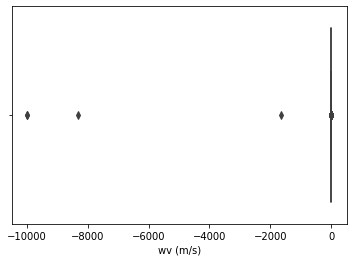

In [9]:
# STUDENT CODE HERE (2 pts)
import seaborn as sns
sns.boxplot(df_resampled['wv (m/s)'])

# Due to the sns plot we can see that all of the unrealistics values are tinier than -1000
for row in range(len(df_resampled)):
    if df_resampled.iloc[row]["wv (m/s)"] < -1000 :
       df_resampled.iloc[row]["wv (m/s)"] = 0.0


for row in range(len(df_resampled)):
    if df_resampled.iloc[row]["max. wv (m/s)"] < -1000 :
       df_resampled.iloc[row]["max. wv (m/s)"] = 0.0

# STUDENT CODE until HERE

df_resampled.describe()

### 2.1.8 Visualization

Finally, let's take a look at our dataset visually to get a feeling for the features. The `pd.DataFrame.plot()` method is a nice feature for this, as it automatically labels everything for us, and even displays date times nicely. Feel free to take a look at different things here and change things around to explore the dataset.

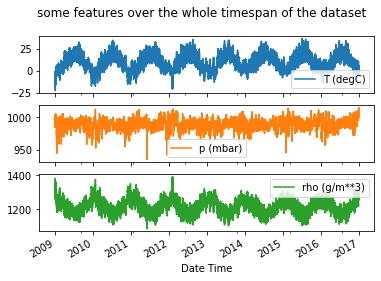

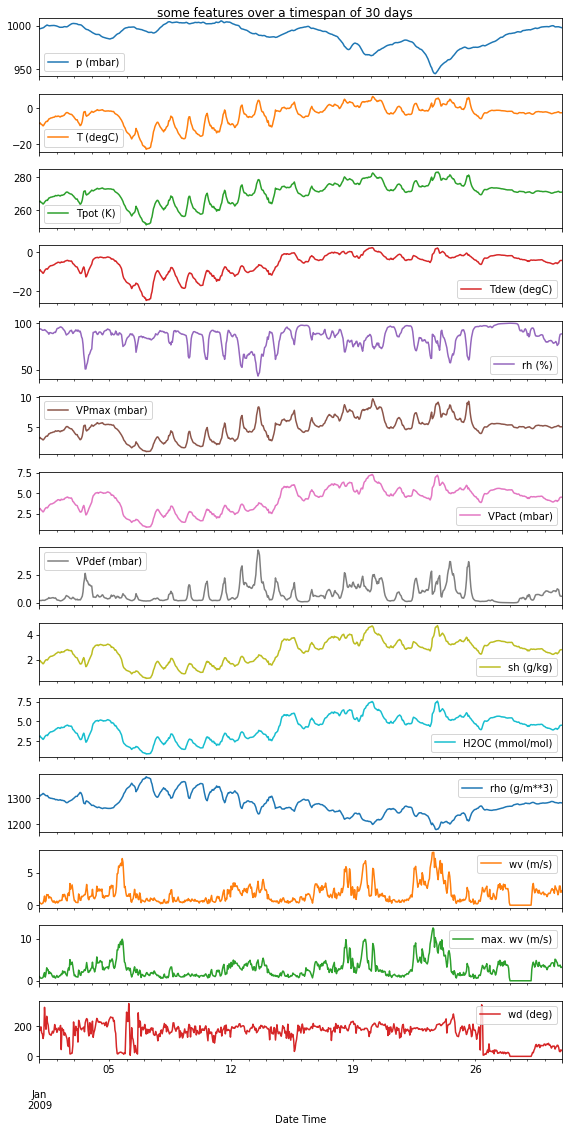

In [10]:
# Some features to plot
# Feel free to change them
plot_cols = ['T (degC)', 'p (mbar)', 'rho (g/m**3)']

# Plot those features over the whole dataset
df_resampled[plot_cols].plot(subplots=True, title='some features over the whole timespan of the dataset')
plt.show()

# Plot all of our features over a shorter timespan
df_resampled[:24 * 30].plot(subplots=True, figsize=(8, 16), title='some features over a timespan of 30 days')
plt.tight_layout()
plt.show()

### 2.1.9 Visualization: periodicity

With time series data, it's always useful to look at the periodicity of the various features. For our weather data, it's already obvious that some features will show strong periodicity with each day and each year, but it's still interesting to find out which features experience what grade of periodicity.

An easy way to analyze the periodicity is to take the fourier transform of the timeseries and look at the spectrogram. 

<div class="alert alert-block alert-success">
<b>Task:</b> Complete the show_spectrum_plot method by plotting the magnitude spectrogram of the fourier transform of the specified feature and add markings for at least the day and year frequency. Hint: the np.fft.rfft() method calculates the fft/dft coefficients for a real-valued timeseries array of arbitrary length. As opposed to the np.fft.fft() method, this one will only return the positive half of the spectrum. Start by plotting the magnitude of these coefficients, and the rest should be relatively easy going from the plot and the various given constants. Second hint: you'll want to scale the x-axis logarithmically to be able to see anything useful. Third hint: calling `plt.xscale()` invalidates previous calls to `plt.xticks()`, so adjust your code to account for that.
</div>

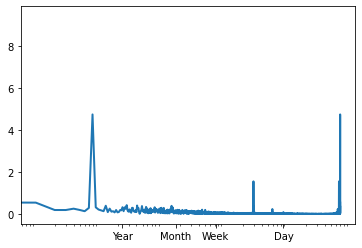

In [11]:
def show_spectrum_plot(dataframe: pd.DataFrame, column_name: str):
    """Computes the discrete fourier transform of the values from a specific
       column of the provided dataframe and shows a plot with the various
       frequency components, with some relevant frequencies (e.g. day, year) annotated.

    Args:
        dataframe (pd.DataFrame): The timeseries dataframe.
        column_name (str): The name of the column of the dataframe to perform the analysis for.
    """
    # Various intervals to use 
    steps_per_day = 24
    steps_per_week = steps_per_day * 7
    steps_per_month = steps_per_day * (365.2425 / 12)
    steps_per_year = steps_per_day * 365.2425
    
    # STUDENT CODE HERE (4 pts)
    X=np.fft.fft(dataframe[column_name])
    X_mag = np.abs(X)/len(dataframe)
    plt.plot(X_mag, lw=2)
    plt.xscale('log')
    plt.xticks([steps_per_day,steps_per_week,steps_per_month,steps_per_year],['Year','Month','Week','Day'])
    plt.show
    # STUDENT CODE until HERE

show_spectrum_plot(df_resampled, 'T (degC)')
# Feel free to explore various other features here
# STUDENT CODE HERE

# STUDENT CODE until HERE

<div class="alert alert-block alert-success">
<b>Question (3 pts):</b> Name three distinct features: one that has both a strong daily & yearly periodicity (1); one that has a significantly stronger daily than yearly periodicity (2); and one that has no visible yearly periodicity (3).
</div>

<div class="alert alert-block alert-success">
<b>Answer:</b>1 T (degC) Temperature 2... 3 p(mbar) air pressure	 </div>

### 2.1.10 Visualization: Autocorrelation

While the fourier transform is something we are familiar with and something that should be really easy to interpret for us, it's not the approach most typically used by other people working on timeseries data. Instead, most of them look at the autocorrelation function (ACF) instead: this method shows how much the values of the timeseries correlate given a specific delay ("lag"). Similarly to when applying a FFT, we again get an insight into the periodicity of our timeseries data, just in a different form. Interpreting them is fairly simple: If the magnitude at some lag is large, this value is significantly correlated to the one at lag 0. So if the autocorrelation at a lag of e.g. 6 hours is large, this either means that there is a periodicity of 1/6 hours in the timeseries, or the values change slow enough that the value after 6 hours of delay can expected to still be near the original value. To differentiate between these two cases, you can look at the surrounding values: if the autocorrelation only has a local peak at that lag, it's probably a periodicity, and if it's rather smooth, it's more likely to just be a slow rate of change.

<div class="alert alert-block alert-success">
<b>Task:</b> Complete the show_acf_plot method by plotting the acf of the specified feature and add markings for at least the hour, day and year frequency. Again, scale the x axis logarithmically. Hint: you can use the `statsmodels.graphics.tsaplots.plot_acf` method, which does most of the heavy lifting for you.
</div>

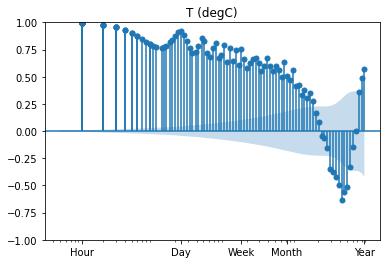

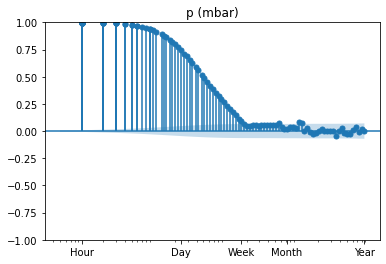

In [12]:
def show_acf_plot(dataframe: pd.DataFrame, column_name: str):
    """Plots the autocorrelation function of a column of the provided dataframe,
    with some relevant frequencies (e.g. day, year) annotated.

    Args:
        dataframe (pd.DataFrame): The timeseries dataframe.
        column_name (str): The name of the column of the dataframe to perform the analysis for.
    """    
    # Various intervals to use
    steps_per_hour = 1
    steps_per_day = 24 * steps_per_hour
    steps_per_week = steps_per_day * 7
    steps_per_month = steps_per_day * (365.2425 / 12)
    steps_per_year = steps_per_day * 365.2425
    
    # The delays to analyze
    # These are 100 exponentially spaced delays between 1 hour and 1 year
    # We should space them exponentially as we are scaling the x axis logarithmically in a moment
    lags = np.exp(np.linspace(np.log(steps_per_hour), np.log(steps_per_year), num=100))
    
    # STUDENT CODE HERE (2 pts)
    statsmodels.graphics.tsaplots.plot_acf(dataframe[column_name],title=column_name, lags=lags)
    plt.xscale("log")
    plt.xticks([steps_per_hour,steps_per_day,steps_per_week,steps_per_month,steps_per_year],["Hour","Day", "Week","Month", "Year"])
    # STUDENT CODE until HERE

show_acf_plot(df_resampled, 'T (degC)')
show_acf_plot(df_resampled, 'p (mbar)')

<div class="alert alert-block alert-success">
<b>Question (2 pts):</b> What behaviour do the two given autocorrelation plots show? What periodicities can be seen, and how large (approximately) is the timespan where the values are still significantly positively correlated?
</div>

<div class="alert alert-block alert-success">
<b>Answer:</b>On the temperature plot we have a high hourly and daily correlation then it decreases till the weekly correlation. After that it decreases till we have an negative correlation. At the end we have an increase of the yearly correlation. For the pressure we have an hourly and a daily correlation, after it decreases rapidly  </div>

## 2.2 Preprocessing

In [13]:
df_resampled.head

<bound method NDFrame.head of                         p (mbar)  T (degC)    Tpot (K)  Tdew (degC)  \
Date Time                                                             
2009-01-01 00:00:00   996.528000 -8.304000  265.118000    -9.120000   
2009-01-01 01:00:00   996.525000 -8.065000  265.361667    -8.861667   
2009-01-01 02:00:00   996.745000 -8.763333  264.645000    -9.610000   
2009-01-01 03:00:00   996.986667 -8.896667  264.491667    -9.786667   
2009-01-01 04:00:00   997.158333 -9.348333  264.026667   -10.345000   
...                          ...       ...         ...          ...   
2016-12-31 20:00:00  1001.410000 -2.503333  270.546667    -7.025000   
2016-12-31 21:00:00  1001.063333 -2.653333  270.426667    -6.970000   
2016-12-31 22:00:00  1000.511667 -3.553333  269.568333    -7.348333   
2016-12-31 23:00:00   999.991667 -3.746667  269.413333    -8.161667   
2017-01-01 00:00:00   999.820000 -4.820000  268.360000    -8.420000   

                        rh (%)  VPmax (mbar)  

### 2.2.1 Feature engineering

Now let's add two features, which indicate the progress in the day and year. These can be used by the model to help with using the periodicities we looked at earlier.

<div class="alert alert-block alert-success">
<b>Task:</b> Add two columns "Time of Day (s)" and "Time of Year (s)", which give the seconds since the start of the year. Hint: if you're working with the datetime library for some calculations and get values off by one or two hours, make sure you're working in UTC time for all of your datetime objects. Another hint: to prevent making it too complex, you may ignore the missing time steps we removed earlier for your time of year calculation. While it's not completely correct to do so, it should not make any significant difference in our case.
</div>

In [14]:
# Create a series of values from our index, which contains the UTC timestamp in seconds
# This series is provided for you incase it makes implementing the provided task easier
# Feel free to use it, or not. There are great viable solutions both ways
if isinstance(df_resampled.index[0], pd.Period):
    utc_timestamps = df_resampled.index.map(pd.Period.to_timestamp).map(pd.Timestamp.timestamp)
    
elif isinstance(df_resampled.index[0], pd.Timestamp):
    utc_timestamps = df_resampled.index.map(pd.Timestamp.timestamp)
else:
    raise AssertionError('The index must consist either of pd.Period or pd.Timestamp objects. This should\'ve triggered an assertion earlier?')
# STUDENT CODE HERE (2 pts)


help_day=utc_timestamps-utc_timestamps[0]
help_day=help_day[0:24]

df_resampled["Time of Day (s)"]=0

help_year=utc_timestamps-utc_timestamps[0]
help_year=help_year[0:366]
print(help_year)
df_resampled["Time of Year (s)"]=0


i = 0

for index,row in df_resampled.iterrows():
    df_resampled.at[index,"Time of Day (s)"]=help_day[i]
    i = i+1
    if i == 24 : 
        i=0
i = 0
        
for index,row in df_resampled.iterrows():
    df_resampled.at[index,"Time of Year (s)"]=help_year[i]
    i = i+1
    if i == 366 : 
        i=0
    
    

# STUDENT CODE until HERE

# Sanity check assertions 
assert df_resampled['Time of Day (s)'][0] == 0, f'Time of day for the first entry was expected to be 0, but found {df_resampled["Time of Day (s)"][0]}s'
assert df_resampled['Time of Day (s)'].max() <= 60 * 60 * 24, f'Time of day was expected to less than a day, but found {df_resampled["Time of Day (s)"].max()}s'
assert df_resampled['Time of Year (s)'][0] == 0, f'Time of year for the first entry was expected to be 0, but found {df_resampled["Time of Year (s)"][0]}s'
assert df_resampled['Time of Year (s)'].max() <= 60 * 60 * 24 * 366, f'Time of year was expected to less than a year, but found {df_resampled["Time of Year (s)"].max()}s'

#df_resampled.head()

Float64Index([      0.0,    3600.0,    7200.0,   10800.0,   14400.0,   18000.0,
                21600.0,   25200.0,   28800.0,   32400.0,
              ...
              1281600.0, 1285200.0, 1288800.0, 1292400.0, 1296000.0, 1299600.0,
              1303200.0, 1306800.0, 1310400.0, 1314000.0],
             dtype='float64', name='Date Time', length=366)


### 2.2.2 Train/validation/test split

As always, we have to split our dataset into training, (validation) and test parts. For this task, it is important that we split the dataset into continous chunks, to minimize the loss of available data at the borders: for each continous chunk of data, we lose 47 (n_in + n_out - 1 in the terminology introduced later) timesteps due to the way we're handling our data, so the more we split it up, the less data is available.

<div class="alert alert-block alert-success">
<b>Task:</b> Implement the splitting of our dataframe df_resampled into train, validation, and test parts. Ensure that the dataframe is split into three continuous chunks and that no shuffling takes place. Otherwise, we end up with discontinuities in our data, which will cause problems later on.
</div>

In [15]:
P_SPLIT_TRAIN, P_SPLIT_VAL, P_SPLIT_TEST = (.7, .2, .1)

df_train: pd.DataFrame
df_val: pd.DataFrame
df_test: pd.DataFrame

# STUDENT CODE HERE (2 pts)
a=int(P_SPLIT_TRAIN*len(df_resampled))
b=int(P_SPLIT_VAL*len(df_resampled))
      
df_train = df_resampled.iloc[0:a]
df_val = df_resampled.iloc[a:a+b]
df_test = df_resampled.iloc[a+b:]

# STUDENT CODE until HERE

### 2.2.2 Normalization/standardization

Let's take a look at our features again. We'll use a violin plot for that, which is generally similar to a box plot, but provides additional information about the exact value distribution of each feature.

**Note**: Most violin plots apply some smoothing (usually Gaussian) to the distribution outlines. This might lead to some confusion, as the boundaries might extend further than expected (e.g. below 0 for normalized variables) due to that smoothing. To prevent that, you can set `cut=0` in seaborn (similar parameters are available in matplotlib etc), which cuts of the distributions at their edges. You can also control the smoothing via the `bw` (bandwidth of the Gaussian) parameter.

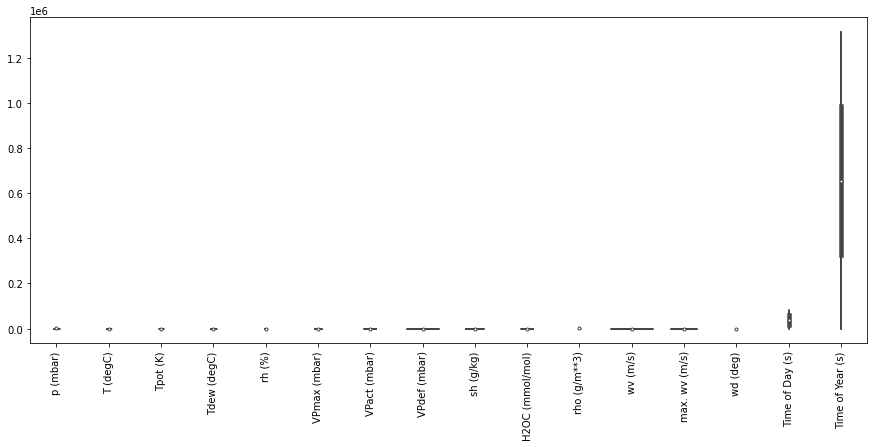

In [16]:
# Plot the value distribution of our features
plt.figure(figsize=(15, 6))
sns.violinplot(data=df_train, bw=.05, cut=0).set_xticklabels(df_train.columns, rotation=90)
plt.show()

As expected, we see wildly different value ranges. To prevent this from having a negative effect on the training of our models, we should normalize them. The choice of standardization vs. normalization is not that important in this case. We'll just use standardization, but feel free to experiment with min-max-normalization, too. Just keep in mind that the choice of scaler also affects the performance metrics, as the outputs are scaled, too.

For this notebook, we will fit a separate scaler to each feature and store them all in a dictionary. That way, we can perform the inverse scaling for single predicted features more easily later on.

<div class="alert alert-block alert-success">
<b>Task:</b> Implement the fit_scalers and apply_scalers methods as described in the respective comments.
</div>

{'p (mbar)': StandardScaler(), 'T (degC)': StandardScaler(), 'Tpot (K)': StandardScaler(), 'Tdew (degC)': StandardScaler(), 'rh (%)': StandardScaler(), 'VPmax (mbar)': StandardScaler(), 'VPact (mbar)': StandardScaler(), 'VPdef (mbar)': StandardScaler(), 'sh (g/kg)': StandardScaler(), 'H2OC (mmol/mol)': StandardScaler(), 'rho (g/m**3)': StandardScaler(), 'wv (m/s)': StandardScaler(), 'max. wv (m/s)': StandardScaler(), 'wd (deg)': StandardScaler(), 'Time of Day (s)': StandardScaler(), 'Time of Year (s)': StandardScaler()}


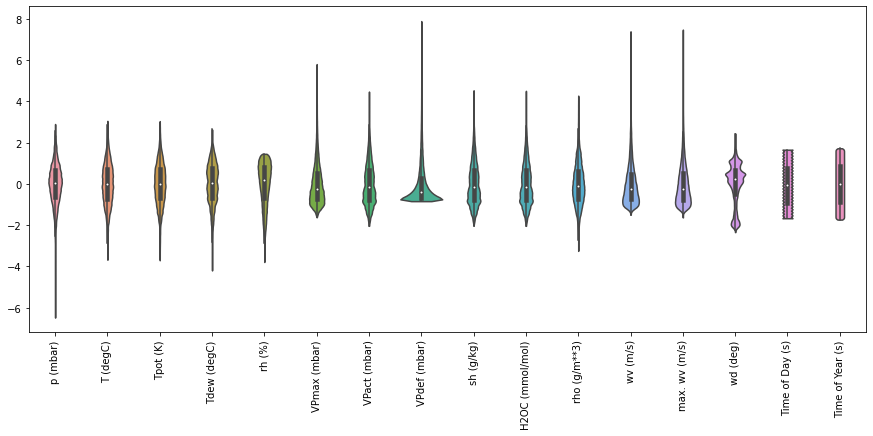

In [17]:
def fit_scalers(data: pd.DataFrame) -> Dict[str, sklearn.preprocessing.StandardScaler]:
    """Fits a separate sklearn.preprocessing.StandardScaler instance to each feature in the provided dataframe
       and returns a dictionary with (column name: scaler instance) format.
       The data inside the dataframe is not modified.

    Args:
        data (pd.DataFrame): The dataframe containing the data the scalers should be fit to.

    Returns:
        Dict[str, sklearn.preprocessing.StandardScaler]: A dictionary containing all of the created scaler instances,
            accessible via their corresponding column name in the dataframe.
    """
    # STUDENT CODE HERE (2 pts)
#     Dict = {}
    
#     for col in data.columns:
#         scaler = sklearn.preprocessing.StandardScaler()
#         data2 = data[col].to_frame()
#         Dict[col] = scaler.fit(X=data2)
        
#     #print(Dict)    
#     return Dict
    return { column_name: sklearn.preprocessing.StandardScaler().fit(np.expand_dims(data[column_name].values, -1)) for column_name in data.columns }
    # STUDENT CODE until HERE

def apply_scalers(data: pd.DataFrame, scalers: Dict[str, sklearn.preprocessing.StandardScaler]) -> pd.DataFrame:
    """Applies a dictionary of previously fit scalers to a dataframe, leaving the data inside the original dataframe
       intact and returning a copy of the dataframe with all of the values scaled.

    Args:
        data (pd.DataFrame): The dataframe to apply the scalers to.
        scalers (Dict[str, sklearn.preprocessing.StandardScaler]): The scalers to apply to the dataframe.

    Returns:
        pd.DataFrame: A copy of the original dataframe, where all of the values have been scaled
            using the supplied scaler instances.
    """
    # STUDENT CODE HERE (2 pts)
#     df = []
#     for col in data.columns:
#         t = data[col].to_frame()
#         df.append(scalers[col].transform(t))
#     df = np.squeeze(df)
#     df = df.T
#     df = pd.DataFrame(df,columns = data.columns)
   
#     print(np.shape(df))
    
#     return df

    output = data.copy(deep=True)
    for column_name, scaler in scalers.items():
        output[column_name] = scaler.transform(np.expand_dims(data[column_name].values, -1))[:, 0]
    return output
    # STUDENT CODE until HERE

# Get the fitted scalers for our dataset
scalers = fit_scalers(df_train)
print(scalers)
# Apply the scalers to our train and validation datasets
# Don't touch the test dataset yet - this way we can prevent accidentally using it somewhere
df_train_scaled = apply_scalers(df_train, scalers)
df_val_scaled = apply_scalers(df_val, scalers)

# Plot the value distribution of our newly scaled features
plt.figure(figsize=(15, 6))
sns.violinplot(data=df_train_scaled, bw=.05, cut=0).set_xticklabels(df_train_scaled.columns, rotation=90)
plt.show()

Now all features should look like they have a reasonable value range, which can easily be processed using our machine learning models. Now that all ranges are similar, the exact value distributions should also be properly visible now.

With that, we're done with our data preprocessing, so we can get started preparing for the actual machine learning part.

# 3 Machine Learning

## 3.1 Preparation

### 3.1.1 Generators
Previously, we have mostly just put all of our data into a single (numpy) array and passed that to our various model fitting methods. In many cases when training neural networks, this will not be a viable option, as your whole training data might be too large to be kept in memory all the time, or as you might want to perform some random augmentation that is different each epoch. For those cases, we can use generators: Instead of giving an array to our model for training, we create a method that returns all of the pairs of inputs (x) and targets (y) one by one, generating them (or loading them from the disk in some cases) on the fly.

Using this generator function, we create a `tf.data.Dataset` from it, which we can then pass to our model for training, validation, testing, or inference.

For this time series prediction task, we'll give $n_{in}$ (e.g. 6) values to the model and then let the model predict the next $n_{out}$ (e.g. 1) values. To do that, we have to take slices of length $n_{in} + n_{out}$ values from our original timeseries and split them such that we obtain two separate arrays for the $n_{in}$ inputs and $n_{out}$ outputs/labels.

<img src="images/data_generation.png" height="300"/>

Of course, these windows be cut out such that they overlap and just move by a single hour for each new sample. This way we obtain more training data.

<div class="alert alert-block alert-success">
<b>Task:</b> Complete the `generate_inputs_outputs()` method.
</div>

In [18]:
def generate_inputs_outputs(df_scaled: pd.DataFrame, input_features: List[str], n_in: int, output_features: List[str], n_out: int) -> tf.data.Dataset:
    """Generates the training/testing dataset from a dataframe with already standardized/normalized features.

    Args:
        df_scaled (pd.DataFrame): The source dataframe.
        input_features (List[str]): The column names used as input features to the model.
        n_in (int): The number of timesteps used as the input to the model.
        output_features (List[str]): The column names used as output features of the model.
        n_out (int): The number of timesteps the model shall predict.

    Returns:
        tf.data.Dataset: A TensorFlow Dataset object containing the training/testing data.
    """
    # Our actual generator function, which will yield tuples of our model input and output data entries
    def generator() -> Iterator[Tuple[np.ndarray, np.ndarray]]:
        # Get the relevant data into a single numpy array first, as the column lookups are really slow
        input_data = df_scaled[input_features].values
        output_data = df_scaled[output_features].values
        
        # Iterate over our dataset, leaving enough space to take (n_in + n_out) samples each time
        for i in range(0, len(df_scaled) - (n_in + n_out)):
            inputs: np.ndarray
            outputs: np.ndarray
            
            # STUDENT CODE HERE (2 pts)
            
            inputs = input_data[i : i + n_in]
            outputs = output_data[i + n_in : i + n_in + n_out]
            
                
            # STUDENT CODE until HERE
            
            # Return the current input & output pair
            # When using the yield keyword as opposed to return, the method will continue,
            # and every new yield statement will return additional data
            yield inputs, outputs
    
    # Create a tf.data.Dataset object from our generator
    # This will later be passed to the model.fit() method
    return tf.data.Dataset.from_generator(generator,
                                          # We need to specify the shapes of the arrays our generator returns
                                          # The format is output_shapes=(inputs.shape, outputs.shape)
                                          # The two exact shape specifications in turn are fairly easily derived from our parameters
                                          output_shapes=((n_in, len(input_features)), (n_out, len(output_features))),
                                          # We have to specify the datatype for each array we return
                                          # The format is again output_types=(inputs.dtype, outputs.dtype)
                                          # BUT we have to specify the tensorflow types, so tf.float32 instead
                                          # of e.g. np.float32, or tf.int64 instead of np.int64
                                          # All of our timeseries values are floats, so we specify tf.float32 for both
                                          output_types=(tf.float32, tf.float32))

# Do a quick test call to see if everything is in order and check the specified parameters
# We'll wrap our testing code inside a method so that we don't clutter the global variables
def _test():
    dataset = generate_inputs_outputs(df_train_scaled, df_train_scaled.columns, 24, ['T (degC)'], 12)
    print(dataset) # This should print <FlatMapDataset shapes: ((24, 16), (12, 1)), types: (tf.float32, tf.float32)>
    # The items in the dataset can be accessed e.g. via a for loop
    # Let's take the first pair from the dataset (the take is optional - if ommitted, the loop will iterate over all entries)
    # and print their shape to take a quick look (in TensorFlow, this is typically done via tf.shape(value), as opposed
    # to the numpy way of just accessing value.shape)
    for inputs, outputs in dataset.take(1):
        # Should return tf.Tensor([24 16], shape=(2,), dtype=int32) -> 24 timesteps x 16 features
        print('Input shape:', tf.shape(inputs))
        # Should return tf.Tensor([12 1], shape=(2,), dtype=int32) -> 12 timesteps x 1 feature
        print('Target shape:', tf.shape(outputs))

_test()

<FlatMapDataset shapes: ((24, 16), (12, 1)), types: (tf.float32, tf.float32)>
Input shape: tf.Tensor([24 16], shape=(2,), dtype=int32)
Target shape: tf.Tensor([12  1], shape=(2,), dtype=int32)


<div class="alert alert-block alert-success">
<b>Question (3 pts):</b> How is using a generator more efficient in this case (can you quantify that with a rough number/formula)? How much of an improvement do you expect? Hint: we're not looking for time efficiency for this question (even if generators will often offer improvements there, too).
</div>

<div class="alert alert-block alert-success">
<b>Answer:</b>Improved Memory efficiency and code is shorter </div>

### 3.1.2 Model data visualization

Let's now take a look at the data we're generating. To do so, we'll implement a method that takes the inputs and targets and displays them in a neat graph (showing only the feature that is also predicted for simplicity). To be able to also use the method later on to visualize our models' performance, let's also add a parameter for displaying model predictions, and label them with the model name in the graph. Finally, also make sure to de-normalize/-standardize the timeseries values.

<div class="alert alert-block alert-success">
<b>Task:</b> Complete the plotting method given below.
</div>

In [19]:
# from sklearn.preprocessing import StandardScaler
# data = [[1,1], [2,3], [3,2], [1,1]]
# scaler = StandardScaler()
# scaler.fit(data)
# scaled = scaler.transform(data)
# print(scaled)
# scaler="hallo"
# scaler = StandardScaler()
# scaler.fit(scaled)
# # for inverse transformation
# inversed = scaler.inverse_transform(scaled)
# print(inversed)

Just inputs & targets


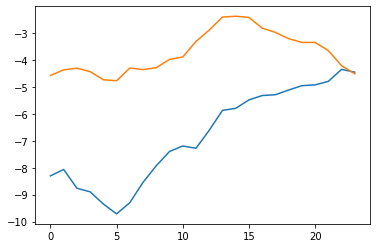

Inputs & targets & (fake) predictions


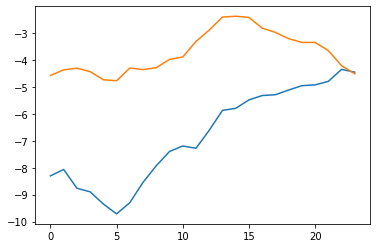

Just inputs & targets


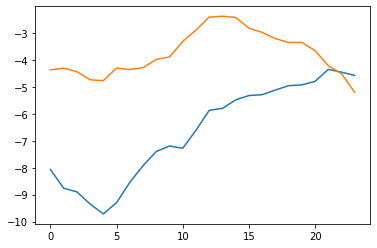

Inputs & targets & (fake) predictions


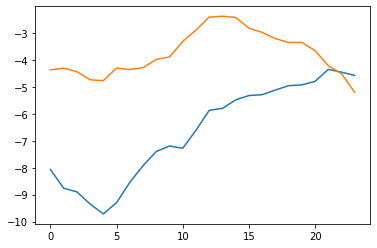

In [30]:

def plot_inputs_outputs(inputs: np.ndarray, targets: np.ndarray, feature_name: str, predictions: Optional[np.ndarray] = None, model_name: Optional[str] = None):
    """Plots the inputs and expected outputs (and the predictions, if given) of a timeseries.

    Args:
        inputs (np.ndarray): The input values. Single-dimensional array containing normalized/standardized values.
        targets (np.ndarray): The target output values. Single-dimensional array containing normalized/standardized values.
        feature_name (str): The feature/column name associated with the supplied timeseries data.
        predictions (Optional[np.ndarray], optional): The predicted output values. Single-dimensional array containing normalized/standardized values. Defaults to None.
        model_name (Optional[str], optional): The model name to display if predictions are given. Defaults to None.
    """
    # STUDENT CODE HERE (4 pts)
    
    scaler = scalers[feature_name]
    #print(scaler)
    inputs_np = inputs.numpy()
    targets_np = targets.numpy()
    #print(inputs_np)
    inputs_np = inputs_np.reshape(-1,1)
    targets_np = targets_np.reshape(-1,1)
    inputs_descaled = scaler.inverse_transform(inputs_np)[:,0]
    targets_descaled = scaler.inverse_transform(targets_np)[:,0]
    
    if predictions is None :
        pass
    else :
        predictions_np = predictions.numpy()
        predictions_np = predictions_np.reshape(-1,1)
        predictions_descaled = scaler.inverse_transform(predictions_np)
    #x = np.linspace(0, len(inputs_descaled),1) 
    #y = inputs_descaled.T
    
    fig, ax = plt.subplots()
    
   
    plt.plot(inputs_descaled)
    
    
    plt.plot(targets_descaled)
    
    plt.show()
        
    
        
        
        
    
    
   
    # STUDENT CODE until HERE



# We'll wrap our testing code inside a method so that we don't clutter the global variables
def _test():
    # Define the inputs and outputs to our hypothetical model and create the dataset
    input_features = ['T (degC)', 'p (mbar)']
    output_features = ['T (degC)']
    dataset = generate_inputs_outputs(df_train_scaled, input_features, 24, output_features, 24)
    # The feature we want to display
    display_feature = 'T (degC)'
    
    # Iterate over the first few entries of the dataset
    for x, y_target in dataset.take(2):
        # Take everything along the first axis of x (all timesteps), but only take the part of the second axis
        # where the feature we want to display is
        x_display = x[:, input_features.index(display_feature)]
        # Same for our targets
        y_target_display = y_target[:, output_features.index(display_feature)]
        
        # Display our data
        print('Just inputs & targets')
        plot_inputs_outputs(x_display, y_target_display, display_feature)
        
        # Now let's create some artificial prediction data to test that feature of our code as well
        print('Inputs & targets & (fake) predictions')
        # The fake predictions are just the targets plus some random noise
        y_predictions_display = y_target_display + .05 * np.random.standard_normal(size=y_target_display.shape)
        plot_inputs_outputs(x_display, y_target_display, display_feature, y_predictions_display, 'Fake Model')

_test()

### 3.1.3 Hyperparameters

To store and manage our hyperparameters, we'll use dictionaries. These allow us to manage all hyperparameters easily and in a way that can easily be passed to various methods. Additionally, we can also easily derive copies with some changed parameters and even easily store them (e.g. as JSON files).

We are providing some hyperparameters here for now.

In [31]:
HYPERPARAMETERS = {
    # Model design hyperparameters
    'input_features': list(df_resampled.columns), # Take all available features for our input
    'input_timesteps': 24, # Use the last 24h of values as the input
    'output_features': ['T (degC)'], # Just predict the temperature for now
    'output_timesteps': 24, # ... and do 24h of predictions for that
    
    # Training hyperparameters
    'optimizer': 'adam',
    'loss': 'mse', # We have a regression problem, so let's use mean-squared-error loss
    'metrics': ['mae'], # Let's also track the mean-absolute-error
    'batch_size': 32,
    'early_stopping_patience': 3, # Train the model until the validation loss hasn't improved for a few epochs, we'll cover this shortly
    'max_epochs': 50, # Train for 50 epochs at most
}

HYPERPARAMETERS

{'input_features': ['p (mbar)',
  'T (degC)',
  'Tpot (K)',
  'Tdew (degC)',
  'rh (%)',
  'VPmax (mbar)',
  'VPact (mbar)',
  'VPdef (mbar)',
  'sh (g/kg)',
  'H2OC (mmol/mol)',
  'rho (g/m**3)',
  'wv (m/s)',
  'max. wv (m/s)',
  'wd (deg)',
  'Time of Day (s)',
  'Time of Year (s)'],
 'input_timesteps': 24,
 'output_features': ['T (degC)'],
 'output_timesteps': 24,
 'optimizer': 'adam',
 'loss': 'mse',
 'metrics': ['mae'],
 'batch_size': 32,
 'early_stopping_patience': 3,
 'max_epochs': 50}

### 3.1.4 Baselines

Something that's really useful to implement in many cases are baseline/dummy models: very simple models that set a performance baseline, which we can compare the performance of our own models to later on. We'll start with two of the most simple baseline models we can try: one that just assumes that the values stop changing and just predicts the last value it received as an input; and one that repeats the last day worth of inputs periodically. Both are decent baselines to compare against in our case: just predicting the last seen value is the simplest possible prediction, and the feature progression of the last 24 hours will also often be a good rough estimate for the next 24 hours. Below, you can see a visualization of both baseline models, where the last value and the values from the last day are repeated.

<img src="images/baseline_repeat.png" height="250"/>
<img src="images/baseline_repeat_day.png" height="250"/>

Here, these two models are already implemented for you. In Keras, implementing these kinds of custom models is fairly straightforward: you only need to inherit from `tf.keras.Model` and overwrite the `tf.keras.Model.call()` method, performing all necessary computations on the inputs there and returning the output. The main limitation in the call methods is that you can only use TensorFlow methods, so no calls to numpy or pandas. Luckily, TensorFlow provides most of the functionality that is present in numpy, too.

As we are dealing with data that has a time dimension here, both our model inputs and outputs will have a dimension reserved for that. Specifically, the input dimension will be `(batch_size, n_in, len(input_features))`, and the output dimension will be `(batch_size, n_out, len(output_features))`, as previously specified in the `generate_inputs_outputs()` method (the `batch_size` isn't present there, but it's added to our models when we build them).

<div class="alert alert-block alert-success">
<b>Task:</b> Complete the test visualization method similar to the last one, but using the hyperparameters from our new dictionary, and visualize the outputs from both baseline models.
</div>

Just inputs & targets


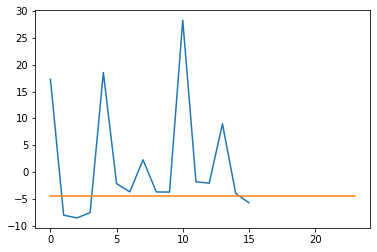

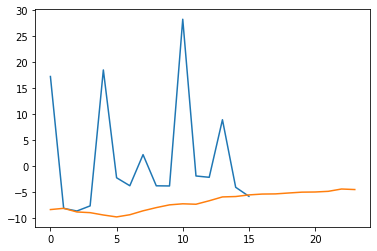

Just inputs & targets


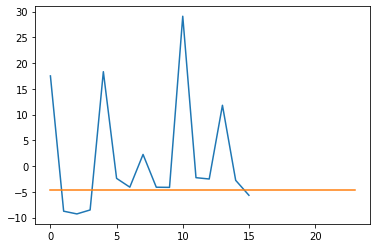

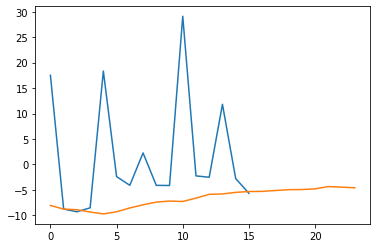

In [34]:
class RepeatLastValueBaselineModel(tf.keras.Model):
    """Simple baseline model that just repeats the last input value indefinitely"""
    
    def __init__(self, hyperparameters: Dict[str, Any]):
        # Call the constructor of the base class _first_
        super().__init__(name='RepeatLastValueBaselineModel')
        
        # Initialize our local variables, taking all of the hyperparameters we're interested in and saving them locally
        self.input_features = hyperparameters['input_features']
        self.output_features = hyperparameters['output_features']
        self.output_timesteps = hyperparameters['output_timesteps']
    
    def call(self, inputs: tf.Tensor) -> tf.Tensor:
        """Calls the model on new inputs.

        Args:
            inputs (tf.Tensor): A tensor containing the input values.

        Returns:
            tf.Tensor: A tensor containing the output values.
        """
        # We might not be predicting all features we receive as inputs
        # So we have to find the indices of the features we want to return as our predictions
        channel_indices_to_relay = [self.input_features.index(feature) for feature in self.output_features]
        
        # Retrieve the last value from each of the channels we are returning
        last_values = [inputs[:, -1:, i_relay] for i_relay in channel_indices_to_relay]
        
        # Put all of the channels we're returning into a single tensor
        single_prediction_step = tf.stack(last_values, axis=-1)
        
        # Repeat the values for as long as we need to, and return
        return tf.tile(single_prediction_step, [1, self.output_timesteps, 1])

class RepeatLastDayBaselineModel(tf.keras.Model):
    """Simple baseline model that just loops the input values from the last day indefinitely."""
    def __init__(self, hyperparameters: Dict[str, Any]):
        # Call the constructor of the base class _first_
        super().__init__(name='RepeatLastDayBaselineModel')
        
        # Initialize our local variables, taking all of the hyperparameters we're interested in and saving them locally
        self.input_features = hyperparameters['input_features']
        assert hyperparameters['input_timesteps'] >= 24, 'Last day repitition baseline can only be used if at least one day of data is available at the input'
        self.output_features = hyperparameters['output_features']
        self.output_timesteps = hyperparameters['output_timesteps']
    
    def call(self, inputs: tf.Tensor) -> tf.Tensor:
        """Calls the model on new inputs.

        Args:
            inputs (tf.Tensor): A tensor containing the input values.

        Returns:
            tf.Tensor: A tensor containing the output values.
        """
        # We might not be predicting all features we receive as inputs
        # So we have to find the indices of the features we want to return as our predictions
        channel_indices_to_relay = [self.input_features.index(feature) for feature in self.output_features]
        
        # Retrieve the last 24 values from each of the channels we are returning
        last_day_values = [inputs[:, -24:, i_relay] for i_relay in channel_indices_to_relay]
        
        # Put all of the channels we're returning into a single tensor
        single_prediction_day = tf.stack(last_day_values, axis=-1)
        
        # Repeat the values for as long as we need to, and return
        # Here, we repeat the last day for a few times, and then take as many values as we need
        return tf.tile(single_prediction_day, [1, int(math.ceil(self.output_timesteps / 24)), 1])[:, :self.output_timesteps, :]



# Run a quick test on our models
def _test():
    # Define the inputs and outputs to our hypothetical model and create the dataset
    # We're using batches of size 1 for now, as it makes things easier for us
    # The batch size itself only really makes a difference during training, so choosing a batch size of 1 for this
    # method only makes things easier for us and doesn't change anything when we're just visualizing/testing our model
    dataset = generate_inputs_outputs(df_train_scaled, HYPERPARAMETERS['input_features'],
                                      HYPERPARAMETERS['input_timesteps'], HYPERPARAMETERS['output_features'],
                                      HYPERPARAMETERS['output_timesteps']).batch(1)
    # The feature we want to display
    display_feature = 'T (degC)'
    
    # The baseline models to test
    repeat_last_value_baseline_model = RepeatLastValueBaselineModel(HYPERPARAMETERS)
    repeat_last_value_baseline_model.build(
        input_shape=(1, HYPERPARAMETERS['input_timesteps'], len(HYPERPARAMETERS['input_features'])))
    repeat_last_day_baseline_model = RepeatLastDayBaselineModel(HYPERPARAMETERS)
    repeat_last_day_baseline_model.build(
        input_shape=(1, HYPERPARAMETERS['input_timesteps'], len(HYPERPARAMETERS['input_features'])))
    
    # Iterate over a few entries of the dataset
    for x_batch, y_batch_target in dataset.take(2):
        # STUDENT CODE HERE (4 pts)
        
        x_display = x_batch[:, HYPERPARAMETERS['input_features'].index(display_feature)]
        # Same for our targets
        y_target_display = y_batch_target[:, HYPERPARAMETERS['input_features'].index(display_feature)]
        
        rlvbm=repeat_last_value_baseline_model.call(x_batch)
        
        rldbm=repeat_last_day_baseline_model.call(x_batch)
        
        print('Just inputs & targets')
        #plot_inputs_outputs(x_display, y_target_display, display_feature)
        plot_inputs_outputs(x_display, rlvbm, display_feature)
        plot_inputs_outputs(x_display, rldbm, display_feature)


        # STUDENT CODE until HERE

_test()

<div class="alert alert-block alert-success">
<b>Question(2 pts):</b> What did you find when looking at the outputs from our baseline models?
</div>

<div class="alert alert-block alert-success">
<b>Answer:</b></div>

### 3.1.5 Early stopping & TensorBoard

Here, we'll also introduce some (potentially) new features that you might not be familiar with yet.

#### Early Stopping
Early stopping is a really useful concept, where we take our validation dataset and use it to continually track the performance of our model while training, calculating our loss and other metrics on it each epoch (this is done automatically if you supply it to the `tf.keras.Model.fit()` method via the `validation_data` argument). We then track this loss and, as soon as the validation loss has stopped improving, we stop the training. This way, we don't have to guess the amount of epochs the model needs to train until it starts to overfit. Instead, we just use the performance on our validation dataset as a proxy for the generalization performance of our model.

This monitoring and stopping is done via the `tf.keras.callbacks.EarlyStopping` callback. As the validation loss does not always go down even if the model is still training properly, we usually add some "patience". This means that the training will only be stopped if no improvement happened over e.g. 5 epochs. When using early stopping, the `epochs` value given to the `tf.keras.Model.fit()` method only serves as an upper bound, specifying the maximum amount of epochs the model is trained for even if the validation loss continues to improve.

#### TensorBoard
TensorBoard is a utility that allows us to track the training progress of our models live. In Keras, we just need to add its callback and specify an output directory (ideally naming our output directory in a way that allows us to recognize the model we trained later). Then, we can start Tensorboard by opening a terminal session in our project folder and then executing `tensorboard --logdir=logs` (the conda/virtualenv environment with our tensorboard installation has to be active for this command to work). Then, we can access TensorBoard via the webbrowser, usually at [http://localhost:6006/](http://localhost:6006/).

For tracking the training progress, you'll want to use the "Scalars" tab. You can then select the models to show in the lower left of the screen. You might want to turn down/disable the smoothing of the graphs in the upper left, and activate automatic reloading (check "reload data" and set a reload period [e.g. 30s] in the settings menu which you can access via the cogwheel in the upper right).

If you're really curious and you have too much spare time on your hands, you can also explore the internals of how our models are executed by checking out the "Graphs" tab. Select a model on the left, and then explore the graph. You can double-click on most nodes to expand them and see what's going on inside. That way, you can get down to the elementary mathematical operations that happen in our models. Try looking at the internals of some of the layers we use in our models and how they work internally or look at how the gradients are computed (there'll usually be some `[...]inference_backward_[...]` node, which contains a `gradients` node, which has the gradient computations).

### 3.1.6 Generic training method

Now let's put all of that together and create a method that trains a model according to the specified hyperparameters. Putting this into a method is beneficial, as we can use it to easily train multiple model variations later.

<div class="alert alert-block alert-success" style=>
<b>Task:</b> Complete the `train_model()` method.
</div>

In [99]:
def train_model(model: tf.keras.Model, hyperparameters: Dict[str, Any]):
    """Trains the specified model instance according to the supplied hyperparameters.

    Args:
        model (tf.keras.Model): The model to train.
        hyperparameters (Dict[str, Any]): The hyperparameters specifying the various aspects of the training
    """
    
    # Compile our model with an optimizer and the loss & metrics we want
    # STUDENT CODE HERE (1 pts)
    model.compile(loss=hyperparameters['loss'], optimizer=hyperparameters['optimizer'], metrics=hyperparameters['metrics'])
    # STUDENT CODE until HERE

    # Build our model with the correct input shape
    # (None [that means variable batch size, which can be useful for testing later], INPUT_TIMESTEPS, len(INPUT_FEATURES))
    model.build(input_shape=(None, hyperparameters['input_timesteps'], len(hyperparameters['input_features'])))
    
    # Print a summary of our model to the terminal
    # This can often be useful when trying to find some problems
    model.summary()
    
    # Create the datasets for training & validation according to our hyperparameters
    # Take the data from the df_train_scaled and df_val_scaled variables from earlier
    train_dataset: tf.data.Dataset
    validation_dataset: tf.data.Dataset
    # STUDENT CODE HERE (1 pts)
    
    train_dataset = generate_inputs_outputs(df_train_scaled,hyperparameters['input_features'],
                                      hyperparameters['input_timesteps'], hyperparameters['output_features'],
                                      hyperparameters['output_timesteps'])
    
    validation_dataset = generate_inputs_outputs(df_val_scaled,hyperparameters['input_features'],
                                      hyperparameters['input_timesteps'], hyperparameters['output_features'],
                                      hyperparameters['output_timesteps'])
    
    print(train_dataset)
    
    # STUDENT CODE until HERE
    
    # Batch the datasets for training & validation according to our hyperparameters using the .batch() method
    # of the tf.data.Dataset
    # Additionally, after batching, shuffle the training dataset with a reasonable buffer size
    # Make sure to overwrite our train_dataset & validation_dataset variables with their batched (& shuffled) versions
    # STUDENT CODE HERE (1 pts)
    
    train_dataset = train_dataset.batch(batch_size=hyperparameters['batch_size'])
    validation_dataset=validation_dataset.batch(batch_size=hyperparameters['batch_size'])
    
    # STUDENT CODE until HERE

    # Create the callbacks to use during training
    callbacks = [
        # Add the early stopping callback here, using our previously specified patience hyperparameter,
        # and setting it to restore the weights of the epoch with the best validation loss
        # STUDENT CODE HERE (1 pts)
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', patience=hyperparameters['early_stopping_patience'],restore_best_weights=True),
        
        # STUDENT CODE until HERE
        
        # The TensorBoard callback needs a base directory (in this case 'logs'), the rest of the path is
        # used for basically naming the model in the user interface
        # We'll display the model name and the time at which the training started to differentiate them in the UI
        tf.keras.callbacks.TensorBoard(log_dir=f'logs/{model.name}/{datetime.datetime.now().strftime("%Y_%m_%d-%H_%M_%S")}')
    ]
    
    # Perform prefetching, which allows the data to be loaded automatically when the model is training on a batch
    # This way, training can be faster, as the model doesn't switch between loading a batch and training on it,
    # but performs both in parallel instead.
    # The AUTOTUNE parameter means that the amount of batches to prefetch is tuned automatically
    train_dataset_prefetched = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)
    print(train_dataset_prefetched)
    # Fit/train our model
    history = model.fit(train_dataset_prefetched, epochs=hyperparameters['max_epochs'], validation_data=validation_dataset, callbacks=callbacks)

    # Plot a graph showing the progression of the training & validation loss over the training epochs
    # STUDENT CODE HERE (3 pts)

    # STUDENT CODE until HERE

    # Plot a graph showing the progression of the training & validation metrics over the training epochs
    # STUDENT CODE HERE (2 pts)

    # STUDENT CODE until HERE

## 3.2 Training

### 3.2.1 Fully-connected

Before we start building our first recurrent model, let's implement a simple fully connected model. This will serve as an additional baseline to compare our recurrent model to. and show us whether 

As we are working with timeseries data, we want the inputs and outputs of our model to have a separate dimension for time. Fully-connected layers however cannot deal with additional dimensions out of the box, as you might have learned in the CNN task. Therefore, we have to first remove the dimensionality at the start of the model by adding a `Flatten` layer and then restore it at the output via a `Reshape` layer. Make sure that the fully-connected (`Dense`) layer before the `Reshape` layer already has the correct number of values - otherwise this will not work.

<img src="images/fully_connected.png" height="400"/>

<div class="alert alert-block alert-success" style=>
<b>Task:</b> Complete the `create_fully_connected_baseline()` method by returning a `Sequential` model, which consists of two hidden fully-connected layers (32 and 64 neurons, ReLU activation for both) and one fully-connected layer without any nonlinearities which computes the output values, adding `Flatten` and `Reshape` layers where needed. Also give a descriptive name to the model, so that we can easily differentiate it from our other models later.
</div>

In [100]:
def create_fully_connected_baseline(hyperparameters: Dict[str, Any]) -> tf.keras.Model:
    """Creates a simple baseline fully connected model according to the supplied hyperparameters.clear

    Args:
        hyperparameters (Dict[str, Any]): The hyperparameters.

    Returns:
        tf.keras.Model: The baseline model.
    """
    # STUDENT CODE HERE (5 pts)
    model = tf.keras.Sequential(name='fully_connected_baselinemodel')
    model.add(tf.keras.layers.Flatten())
    
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    
    model.add(tf.keras.layers.Dense(32, activation='relu'))
    
    model.add(tf.keras.layers.Dense(24, activation='relu'))
    
    return model
    # STUDENT CODE until HERE

# Create a model instance
model_fully_connected = create_fully_connected_baseline(HYPERPARAMETERS)

# Train our model
train_model(model_fully_connected, HYPERPARAMETERS)

Model: "fully_connected_baselinemodel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 384)               0         
_________________________________________________________________
dense_97 (Dense)             (None, 64)                24640     
_________________________________________________________________
dense_98 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_99 (Dense)             (None, 24)                792       
Total params: 27,512
Trainable params: 27,512
Non-trainable params: 0
_________________________________________________________________
<FlatMapDataset shapes: ((24, 16), (24, 1)), types: (tf.float32, tf.float32)>
<PrefetchDataset shapes: ((None, 24, 16), (None, 24, 1)), types: (tf.float32, tf.float32)>
Epoch 1/50
1530/1530 [==============================] - 7s 5ms

In [ ]:
7s 4ms/step - loss: 0.5555 - mae: 0.5212 - val_loss: 0.3806 - val_mae: 0.4743


### 3.2.2 Recurrent Neural Networks

#### Theoretical introduction

<img src="images/vanilla_rnn.png" height="400"/>
<img src="images/rnn_cell.png" height="400"/>

Now let's get to recurrent neural networks. We will start with their most basic form, often called "vanilla" RNN. What makes recurrent neural networks special is that they don't process all inputs at once. Instead, they go through the inputs step by step, processing each timestep separately (but with the same parameters at each timestep!). Instead of just outputing their result to the next layer like a CNN however, they also output an additional value to the cell at the next timestep. The vanilla RNN cell can be seen below: It gets an input $x_t$ from the previous layer/model input and an input $h_{t-1}$ from the cell at the previous timestep (if the cell is processing the first timestep, the value is usually set to 0). These values are then processed like in a typical dense layer, put through an activation function (e.g. tanh), which then results in an output $h_t$. This output is then both passed to the next layer and to the cell at the next timestep. In matrix notation, the cell can be modelled like this:
$$h_t = \tanh\left(w_{hh}h_{t-1} + \textbf{w}_{xh}\textbf{x}_t + b_h\right)$$
with the weights $w_{hh}$ and $\textbf{w}_{xh}$, the bias $b_h$, and the activation function $\tanh(\cdot)$.

In practice, we don't just have a single cell per timestep but use multiple cells in parallel, just like we usually use multiple nodes in a fully-connected layer, resulting in the $h$ scalars becoming vectors and our weights becoming matrices:
$$\textbf{h}_t = \tanh\left(\textbf{W}_{hh}\textbf{h}_{t-1} + \textbf{W}_{xh}\textbf{x}_t + \textbf{b}_h\right)$$

If we then stack multiple recurrent layers after each other like in our model, the output $\textbf{h}_t$ from the last layer becomes the input $\textbf{x}_t$ from the next.

When we want to finally get an output from our model, we often just use the vector $\textbf{h}_t$ from the last timestep (this is called "many to one"). In our case, we transform this vector one last time via a fully-connected layer, which then outputs the forecast values. In Keras, to control whether we get all $\textbf{h}_t$ values or just the one from the last timestep in our next layer, we can use the `return_sequences` parameter of any recurrent layer. Set it to `True` if you want to return all timesteps, and to `False`, otherwise.

So why do we do all of this? Similar to CNNs, we create units (here they're called cells, in CNNs they're called kernels) which are applied over one (or, in the case of CNNs, potentially multiple) dimension of the input, performing a calculation at each step. Similar to CNNs, this can be used to find, analyze & exploit local patterns. Additionally, RNNs are able to continously perform calculations at each timestep, whose results are then available to the next timesteps. This enables the handling of particularly complex data like text, where the local relationships vary wildly, something that CNNs are not made for. Additionally, similar to CNNs, the number of parameters does not change with the input size (in the dimension that is used for recurrency). Additionally, we can continue to run the model even after the input data has ended (inputting zeros usually) to produce additional outputs. This approach is often used in recurrent models that output text, to allow them to write arbitrarily long text outputs, by letting them output more characters/words until a specific output is returned that indicates the end of the output sequence.

Previously, "many to one" was mentioned as a possible setup for RNNs. In practice, there are 4 different setups, as shown in the figure below:

<img src="images/RNN-architectures.png" height="300"/>

Source: *K. Greff, R. K. Srivastava, J. Koutník, B. R. Steunebrink, and J. Schmidhuber, “LSTM: A Search Space Odyssey,” Trans. Neural Networks Learn. Syst., 2017.*

- **One to one**: Effectively just a normal feedforward model
- **One to many**: One input to multiple outputs. This might e.g. be used for image captioning (image -> text description of what's visible in the image)
- **Many to one**: Multiple inputs to a single (vector of) output(s). We use this to obtain the features used by our fully-connected layer, which then constructs the forecast, but this can also be used e.g. for text sentient analysis
- **Many to many**: This setup has to be differentiated by when the outputs are generated
    - Asynchronously: The outputs are generated after the whole input sequence has been consumed. This is often used for text-to-text tasks.
    - Synchronously: Outputs are generated for each step in the input sequence. This is used for e.g. framewise segmentation in videos.

#### Task

<div class="alert alert-block alert-success" style=>
<b>Task:</b> Complete the `create_vanilla_rnn()` method by returning a `Sequential` model in the same way as the previous `create_fully_connected_baseline()` method. Use the same architecture (layer node count & activation function) as previously, but make the first two layers recurrent (use the `SimpleRNN` layer).
</div>

In [121]:
def create_vanilla_rnn(hyperparameters: Dict[str, Any]) -> tf.keras.Model:
    """Creates a vanilla RNN model according to the supplied hyperparameters.

    Args:
        hyperparameters (Dict[str, Any]): The hyperparameters.

    Returns:
        tf.keras.Model: The baseline model.
    """
    # STUDENT CODE HERE (5 pts)
    model = tf.keras.Sequential(name='fully_connected_baselinemodel')
    
    model.add(tf.keras.layers.SimpleRNN(32, activation='relu',return_sequences=True))
    
    model.add(tf.keras.layers.SimpleRNN(64, activation='relu'))
    
    model.add(tf.keras.layers.Flatten())
    
    model.add(tf.keras.layers.Dense(24, activation='relu'))
   
    return model
    
    # STUDENT CODE until HERE

# Create a model instance
model_rnn = create_vanilla_rnn(HYPERPARAMETERS)

# Train our model
train_model(model_rnn, HYPERPARAMETERS)

Model: "fully_connected_baselinemodel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_37 (SimpleRNN)    (None, 24, 32)            1568      
_________________________________________________________________
simple_rnn_38 (SimpleRNN)    (None, 64)                6208      
_________________________________________________________________
flatten_10 (Flatten)         (None, 64)                0         
_________________________________________________________________
dense_126 (Dense)            (None, 24)                1560      
Total params: 9,336
Trainable params: 9,336
Non-trainable params: 0
_________________________________________________________________
<FlatMapDataset shapes: ((24, 16), (24, 1)), types: (tf.float32, tf.float32)>
<PrefetchDataset shapes: ((None, 24, 16), (None, 24, 1)), types: (tf.float32, tf.float32)>
Epoch 1/50
1530/1530 [==============================] - 176s 115

### 3.2.3 LSTMs

#### Theoretical introduction

<img src="images/lstm.png" height="400"/>
<img src="images/lstm_cell.png" height="400"/>


In practice, vanilla RNNs face some issues, the most important of which being the instability of the gradients: when training vanilla RNN layers, the gradients over the recurrent dimension often either vanish or explode, which limits their training ability significantly. To alleviate this problem, LSTM (long short-term memory) models were introduced, which feature more complex cells, which solve those problems. Viewed from the outside, they work almost identical to vanilla RNNs, except for the fact that they pass a second value along the recurrent dimension - the cell state $\textbf{c}_t$. Internally, they might look extremely complex at first, but they're actually not _that_ bad:

- Let's start with the **forget gate**: This is basically a fully-connected layer that takes both $h_{t-1}$ and $\textbf{x}_t$ and outputs a value between 0 and 1 (due to the sigmoid activation). If the output of the forget gate is 0, the previous cell state $c_{t-1}$ is multiplied with 0 at the block above, resulting in the previous cell state being _forgotten_. Otherwise, the previous cell state will be either fully or partially remembered and passed along to the next part of the cell.
- Now comes the "heart" of the LSTM cell: like with the vanilla RNN cell, we (usually) take $\tanh$ activation and process both $h_{t-1}$ and $\textbf{x}_t$, computing a new input to the cell state. Additionally, we have the **input gate**, which - similar to the forget gate earlier - decides how much that new cell state input should affect the cell state.
- The gated part of the previous cell state is then summed up with the gated input, giving us our new cell state $c_{t}$.
- This new cell state $c_{t}$ is then run through a (usually) $\tanh$ activation (no matrix multiplication or bias, hence only a blue block in the figure, not an orange one). Finally, we have another gate, this time called **output gate**, which decides whether we even want to output something in this cell at this timestep, after which we also get our output $h_t$.

Mathematically, the LSTM cell can be described as follows:
$$f_t = \sigma\left(w_{hf}h_{t-1} + \textbf{w}_{xf}\textbf{x}_t + b_f\right)$$
$$i_t = \sigma\left(w_{hi}h_{t-1} + \textbf{w}_{xi}\textbf{x}_t + b_i\right)$$
$$\tilde{c}_t = \tanh\left(w_{hc}h_{t-1} + \textbf{w}_{xc}\textbf{x}_t + b_c\right)$$
$$c_t = f_t c_{t-1} + i_t \tilde{c}_t$$
$$o_t = \sigma\left(w_{ho}h_{t-1} + \textbf{w}_{xo}\textbf{x}_t + b_o\right)$$
$$h_t = o_t \tanh\left(c_t\right)$$

This can of course be extended to multiple cells in parallel as previously done with RNN cells, but we'll skip the mathematical notation for that, as it's just the same changes as before, and because it will most probably not be useful for a better understanding.

#### Task
Now, we'll try to build our first model that utilizes LSTM layers. As LSTM cells are usually "more powerful" in practice than vanilla RNN cells, we'll use a reduced number of cells and layers.

<div class="alert alert-block alert-success">
<b>Task:</b> Complete the `create_simple_lstm()` method by returning a `Sequential` model in the same way as the previous `create_fully_connected_baseline()` method. This time, the model should consist of a LSTM layer (25 nodes - the number of nodes does not have to relate to anything, just like in the hidden layers of a fully-connected model) followed by the fully-connected output.
</div>

In [124]:
def create_simple_lstm(hyperparameters: Dict[str, Any]) -> tf.keras.Model:
    """Creates a simple LSTM model according to the supplied hyperparameters.

    Args:
        hyperparameters (Dict[str, Any]): The hyperparameters.

    Returns:
        tf.keras.Model: The baseline model.
    """
    # STUDENT CODE HERE (4 pts)
    model = tf.keras.Sequential(name='simple_lstm')
    
    model.add(tf.keras.layers.LSTM(25))
    
    model.add(tf.keras.layers.Dense(24, activation='relu'))
   
    return model

    # STUDENT CODE until HERE

# Create a model instance
model_lstm = create_simple_lstm(HYPERPARAMETERS)

# Train our model
train_model(model_lstm, HYPERPARAMETERS)

Model: "simple_lstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 25)                4200      
_________________________________________________________________
dense_127 (Dense)            (None, 24)                624       
Total params: 4,824
Trainable params: 4,824
Non-trainable params: 0
_________________________________________________________________
<FlatMapDataset shapes: ((24, 16), (24, 1)), types: (tf.float32, tf.float32)>
<PrefetchDataset shapes: ((None, 24, 16), (None, 24, 1)), types: (tf.float32, tf.float32)>
Epoch 1/50
1530/1530 [==============================] - 14s 7ms/step - loss: 0.6061 - mae: 0.5715 - val_loss: 0.3864 - val_mae: 0.4818
Epoch 2/50
1530/1530 [==============================] - 10s 7ms/step - loss: 0.5634 - mae: 0.5314 - val_loss: 0.3807 - val_mae: 0.4742
Epoch 3/50
1530/1530 [==============================] - 10s 7ms/step - loss:

## 3.3 Evaluation

### 3.3.1 Metric-based evaluation

Now that we've trained a range of models, let's analyze their performance. To do that, we'll analyze the models' performance on the test set, as measured by our loss and additional metric(s). To gain additional insights, we'll not only look at the average loss/metric values over the whole test set, but also take a look at the distribution of those values: by computing each metric for each sample (by using a batch size of 1, so each batch equals one sample) and storing them, we can then plot them in a violin plot (or any other distribution plot of your liking). This then enables analyzing the distribution of the loss/metric values on the test dataset, allowing us to understand how good the model gets at its best, how bad it performs at its worst, etc, as opposed to just understanding how well it performs on average.

To do this in practice, we'll implement a `evaluate_batchwise()` method, which takes a model to test and a test dataset, and returns batchwise evaluation metrics.

Additionally, we'll implement a `evaluate_models()` method, which takes a list of models, evaluates all of them one by one, and outputs both the normal performance metrics (average metrics on the test set), and generates a violin plot showing the metric distribution for all models besides each other. Optionally, the method will also add instances of our two baseline models to the comparison and evaluate them, too.

<div class="alert alert-block alert-success">
<b>Task:</b> Complete the `evaluate_batchwise()` and `evaluate_models()` methods.
</div>

In [126]:
def evaluate_batchwise(model: tf.keras.Model, dataset: tf.data.Dataset, hyperparameters: Dict[str, Any]) -> Dict[str, List[float]]:
    """Evaluates the performance of the supplied model and returns the loss and performance metrics for each batch.

    Args:
        model (tf.keras.Model): The model to evaluate.
        dataset (tf.data.Dataset): The test dataset.

    Returns:
        Dict[str, List[float]]: A dictionary containing the performance of each batch on each metric.
    """
    test_results: Dict[str, List[float]] = { metric: [] for metric in ['loss'] + hyperparameters['metrics'] }
    
    # Go over all batches in the test dataset, test the model on them,
    # and compute the loss + metrics for each batch, storing them in the test_results dict
    # Hint: the model.test_on_batch() method might come in handy
    # STUDENT CODE HERE (3 pts)
    # Iterate over all batches (in this case over all samples, as the batch size is 1)
    for x, y_true in dataset:
        # Test the model on the current batch, computing all necessary metrics
        results = model.test_on_batch(x, y_true, return_dict=True)
        for key in results:
            if key in test_results:
                test_results[key].append(results[key])
            else:
                test_results[key] = [results[key]]
    # STUDENT CODE HERE
    return test_results

def evaluate_models(models: List[tf.keras.Model], hyperparameters: Dict[str, Any], include_baselines: bool = False):
    """Evaluates the performance of the supplied models on the test dataset and creates a violin plot 

    Args:
        models (List[tf.keras.Model]): The models to evaluate.
        hyperparameters (Dict[str, Any]): The hyperparameters the supplied models used.
        include_baselines (bool, optional): Whether to add the repeat-last-value and repeat-last-day baseline models
            to the evaluation. Defaults to False.
    """
    # Create instances of our baseline models (last value & last day) if include_baselines is set to True
    # and add them to the models list. Don't forget to compile them
    # STUDENT CODE HERE
    if include_baselines:
        # The baseline models to test
        repeat_last_value_baseline_model = RepeatLastValueBaselineModel(hyperparameters)
        repeat_last_value_baseline_model.compile(loss=hyperparameters['loss'], metrics=hyperparameters['metrics'])
        repeat_last_day_baseline_model = RepeatLastDayBaselineModel(hyperparameters)
        repeat_last_day_baseline_model.compile(loss=hyperparameters['loss'], metrics=hyperparameters['metrics'])
        
        # Add them to the test model list
        models = [repeat_last_value_baseline_model, repeat_last_day_baseline_model] + models
    # STUDENT CODE until HERE
    
    # Create our test dataset instance and batch it with a batch size of 1
    test_dataset: tf.data.Dataset
    # STUDENT CODE HERE
    test_dataset = generate_inputs_outputs(apply_scalers(df_test, scalers), hyperparameters['input_features'],
                                           hyperparameters['input_timesteps'], hyperparameters['output_features'],
                                           hyperparameters['output_timesteps']).batch(1)
    # STUDENT CODE until HERE

    # Run the evaluate_batchwise() method on all of our models and store the results in the test_results list
    # Also print the mean of all metrics for each model alongside its name
    test_results: List[Dict[str, List[float]]] = []
    # STUDENT CODE HERE
    for model in models:
        print(model.name)
        batchwise_results = evaluate_batchwise(model, test_dataset, HYPERPARAMETERS)
        test_results.append(batchwise_results)
        for metric in ['loss'] + hyperparameters['metrics']:
            print(f' - {metric}: {np.mean(batchwise_results[metric])}')
    # STUDENT CODE until HERE

    # Plot a violin plot showing the loss distributions of our various models
    plt.figure(figsize=(15, 6))
    plt.title('test loss comparison')
    sns.violinplot(data=[results['loss'] for results in test_results], bw=.05, cut=0).set_xticklabels([model.name for model in models])
    plt.ylabel(hyperparameters['loss'])
    plt.show()

    # For every metric, plot a violin plot showing the loss distributions of our various models
    # STUDENT CODE HERE
    for metric in hyperparameters['metrics']:
        plt.figure(figsize=(15, 6))
        plt.title(f'test {metric} comparison')
        sns.violinplot(data=[results[metric] for results in test_results], bw=.01, cut=0).set_xticklabels([model.name for model in models])
        plt.ylabel(metric)
        plt.show()
    # STUDENT CODE until HERE

RepeatLastValueBaselineModel
 - loss: 0.27928996861139993
 - mae: 0.3952338370513168
RepeatLastDayBaselineModel
 - loss: 0.12633890691324182
 - mae: 0.2728912792526429
fully_connected_baselinemodel
 - loss: 0.28524265102016816
 - mae: 0.38614963375700795
fully_connected_baselinemodel
 - loss: 0.3271643481071751
 - mae: 0.41753271061467784
simple_lstm
 - loss: 0.25352924959348544
 - mae: 0.3611138832893792


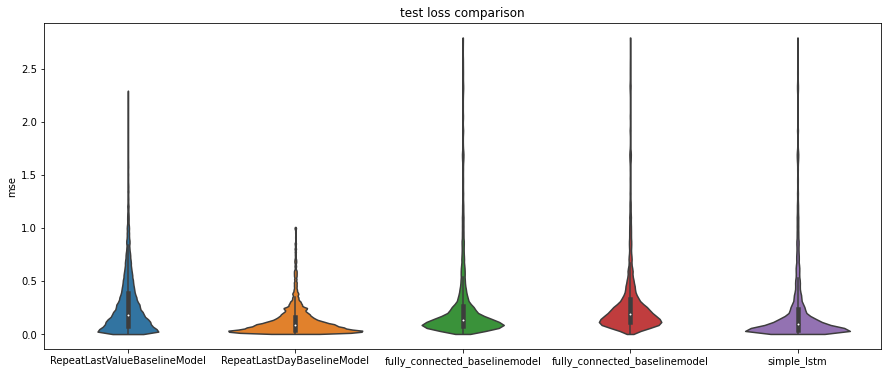

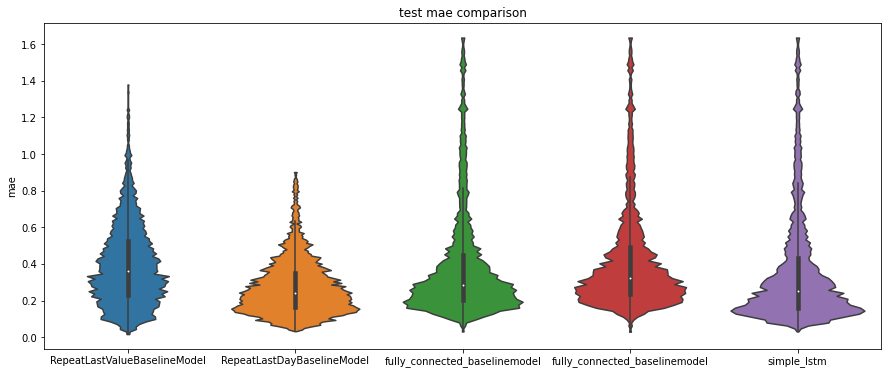

In [127]:
# Evaluate our fully-connected and lstm temperature predictions models alongside our two baseline models
evaluate_models([model_fully_connected, model_rnn, model_lstm], HYPERPARAMETERS, include_baselines=True)

<div class="alert alert-block alert-success">
<b>Question (3 pts):</b> How do our three models compare to the baselines and to each other? What does that mean for our models? Hint: You don't have to compare both the MSE and MAE, just choose one to base your comparison on. Additionally, assume that the models perform basically as good as would be possible for their respective types (the specified architectures have been roughly optimized by us beforehand by evaluating a few dozen architectures each).
</div>

<div class="alert alert-block alert-success">
<b>Answer:</b></div>

<div class="alert alert-block alert-success">
<b>Question (2 pts):</b> What additional information can a violin plot of the samplewise metrics give us compared to just the mean value for said metric?
</div>

<div class="alert alert-block alert-success">
<b>Answer:</b></div>

### 3.3.2 Visual evaluation

Now that we've evaluated our models via our accuracy metrics, let's also take a look at the outputs visually. Numbers often only tell half the story, and a MSE or MAE value of 0.1 doesn't really mean anything to us, especially so as we are computing them on the scaled values: if we wanted to just improve the metrics tenfold, we could just adjust the scaling to divide the values by then when scaling. In practice, as long as all models perform the exact same task, we can use these regression metrics to compare them to each other, but to judge their actual performance, we have to either use other metrics which mean something to us (where "we" don't know any right now) or just take a look at how reasonable the outputs look. The latter option is what we're doing now.

In our case, the simplest way of visually judging the performance of our models is to just plot the inputs, predictions & targets in a plot and see how good our models actually perform visually.

<div class="alert alert-block alert-success">
<b>Task:</b> Complete the `plot_example_outputs()` method, performing a prediction with the supplied model and plot everything using the `plot_inputs_outputs` model.
</div>

In [ ]:
def plot_example_outputs(model: tf.keras.Model, hyperparameters: Dict[str, Any], display_feature: str, n: int):
    test_dataset = generate_inputs_outputs(apply_scalers(df_test, scalers), hyperparameters['input_features'], hyperparameters['input_timesteps'], hyperparameters['output_features'], hyperparameters['output_timesteps']).batch(32)
    
    # Iterate over a few entries of the dataset
    # for x, y_target in test_dataset.shard(hyperparameters['input_timesteps'], 0).take(n):
    for x, y_target in test_dataset.take(n):
        # Predict the future values using the whole batch, and then take the last entry of the batch and visualize that,
        # showing the inputs, targets and predictions from the model for the specified display feature
        ### STUDENT CODE HERE (3 pts)
        
        
        
        # STUDENT CODE until HERE



for model in [model_fully_connected, model_rnn, model_lstm]:
    print(model.name)
    plot_example_outputs(model, HYPERPARAMETERS, HYPERPARAMETERS['output_features'][0], 5)

<div class="alert alert-block alert-success">
<b>Question (1 pts):</b> How would you judge the performance of the various models visually?
</div>

<div class="alert alert-block alert-success">
<b>Answer:</b></div>

## 3.4 New tasks

Based on all things we have implemented previously, you should be able to create and evaluate models to predict other features (or even multiple at once) without having to write much code at all.

**Note**: the following tasks take relatively long to execute (approx 10-15min each on the pool PCs) when properly training & testing the models, as is to be expected when training and evaluating 3 models 3 times each. During development, we suggest to limit the training of the models to a single epoch via the `max_epochs` hyperparameter. When everything works well using a single epoch, remove the limitation and run it again. All tasks can be done using almost exactly the same code, with just some minor modifications, so this testing can probably be omitted for the second and third task.

### 3.4.1 Pressure

Pressure is different from temperature in the way that it has no significant daily periodicity, so repeating the progression from the last day as a forecast is probably not very useful. Let's see how our models perform when predicting this feature.

<div class="alert alert-block alert-success">
<b>Task:</b> Train instances of our fully-connected, vanilla RNN and LSTM models to predict the pressure of the next 24 hours based on inputs (all features) of the last 24 hours and evaluate them.
</div>

In [ ]:
### STUDENT CODE HERE (6 pts)

# STUDENT CODE until HERE

<div class="alert alert-block alert-success">
<b>Question (2 pts):</b> How do the various models (and baselines) perform for this task? Also relate that to their performance on temperature forecasting.
</div>

<div class="alert alert-block alert-success">
<b>Answer:</b></div>

### 3.4.2 Fully univariate timeseries forecasting

Up until now, we've always provided all features we have to our models, even though we were only forecasting a single feature. Let's see if that actually helps improve performance.

<div class="alert alert-block alert-success">
<b>Task:</b> Train instances of our fully-connected, vanilla RNN and LSTM models to predict the temperature of the next 24 hours based on just the temperature of the last 24 hours and evaluate them.
</div>

In [ ]:
### STUDENT CODE HERE (5 pts)

# STUDENT CODE until HERE

<div class="alert alert-block alert-success">
<b>Question (2pts):</b> How does the performance of the fully univariate temperature forecasting models compare to the previous ones? What does that mean for the dependency of temperature on other features?
</div>

<div class="alert alert-block alert-success">
<b>Answer:</b></div>

<div class="alert alert-block alert-success">
<b>Task:</b> Train instances of our fully-connected, vanilla RNN and LSTM models to predict the pressure of the next 24 hours based on just the pressure of the last 24 hours and evaluate them.
</div>

In [ ]:
### STUDENT CODE HERE (4 pts)

# STUDENT CODE until HERE

<div class="alert alert-block alert-success">
<b>Question (1 pts):</b> How does the performance of the fully pressure temperature forecasting models compare to the previous ones? What does that mean for the dependency of pressure on other features?
</div>

<div class="alert alert-block alert-success">
<b>Answer:</b></div>

# 4 Recap & Feedback

## 4.1 Recap
<div class="alert alert-block alert-success">
<b>Question (3pts):</b> Please conclude (in a few sentences) what you learned in this exercise.
</div>

<div class="alert alert-block alert-success">
<b>Answer:</b></div>

## 4.2 Feedback
As this is a completely new task developed from the ground up, feedback is especially welcome. Whatever it is that you notice or that comes to mind, please leave it here, so that we can improve it for the future :)

#### 1 Do you think this task was designed well?


#### 2 Where can we improve this task?


#### 3 Is there anything this task did differently that you'd liked to have seen in previous tasks in a similar way?
Small tips like "its ok to copy code from above" in task 2.1.5 really help me to understand what the task settter wants me to do. 